In [11]:
# --- User Inputs and Constants ---
sun_hours_per_day = 5       # Effective sun hours per day in Spain (approx; true average ~4–5 hours)
night_hours = 12           # Hours without sun (assume 12h for sizing storage)

annual_mwh = 248_000_000   # Updated: total annual electricity demand in MWh (REE forecast ~248 TWh:contentReference[oaicite:6]{index=6})
fossil_share = 0.23        # Updated: fraction met by fossil fuels (about 23% of generation in 2024:contentReference[oaicite:7]{index=7})

cost_per_mwh_fossil = 80    # Assumed cost of fossil generation [€/MWh]; this might vary with fuel prices
cost_per_mwh_solar_opex = 10  # O&M cost for solar generation [€/MWh]

solar_install_cost_per_mw = 1_000_000  # CAPEX for solar PV [€/MW] (≈€1000/kW, optimistic baseline)
storage_cost_per_kwh = 100            # CAPEX for storage [€/kWh] (battery pack cost, optimistic estimate)

battery_efficiency = 0.90  # Round-trip efficiency of batteries (assume ~90%)


In [12]:
# --- Sizing Calculations ---
# Compute the fossil-derived energy we aim to replace
fossil_annual_mwh = annual_mwh * fossil_share
fossil_daily_mwh = fossil_annual_mwh / 365.0

# Required solar capacity: produce fossil_daily_mwh energy in 'sun_hours_per_day' hours
solar_capacity_mw = fossil_daily_mwh / sun_hours_per_day

# Storage needed: cover the fossil demand during night hours (assume constant daily profile)
# Unadjusted storage (no inefficiency): daily * (night_hours/24)
# Adjust for round-trip efficiency: need more capacity to offset losses
storage_needed_gwh = (fossil_daily_mwh * (night_hours / 24)) / (1000 * battery_efficiency)

# Print intermediate sizing results
print(f"Annual fossil-derived demand to replace: {fossil_annual_mwh:,.0f} MWh/year")
print(f"Average daily fossil demand to replace:   {fossil_daily_mwh:,.0f} MWh/day")
print(f"Required solar capacity:                 {solar_capacity_mw:,.0f} MW (at {sun_hours_per_day} sun hrs/day)")
print(f"Storage energy capacity needed:          {storage_needed_gwh:,.0f} GWh (for {night_hours}h; 90% eff.)")


Annual fossil-derived demand to replace: 57,040,000 MWh/year
Average daily fossil demand to replace:   156,274 MWh/day
Required solar capacity:                 31,255 MW (at 5 sun hrs/day)
Storage energy capacity needed:          87 GWh (for 12h; 90% eff.)


In [13]:
import numpy as np

# Annual cost of fossil generation to displace
annual_fossil_cost = fossil_annual_mwh * cost_per_mwh_fossil

# For full (100%) replacement target:
target = 1.0  # fraction of fossil generation replaced
# Compute scaled capacities for this target
solar_cap_target_mw = solar_capacity_mw * target
storage_target_gwh = storage_needed_gwh * target

# Calculate investments for this target
solar_investment = solar_cap_target_mw * solar_install_cost_per_mw
storage_investment = storage_target_gwh * 1e6 * storage_cost_per_kwh  # convert GWh to kWh
total_investment = solar_investment + storage_investment

# Annual savings for this target
annual_solar_opex = fossil_annual_mwh * target * cost_per_mwh_solar_opex
annual_savings = annual_fossil_cost * target - annual_solar_opex

# Simple ROI: payback years (investment / annual net savings)
if annual_savings > 0:
    roi_years = total_investment / annual_savings
else:
    roi_years = np.nan

print("For 100% replacement of fossil generation (solar+storage):")
print(f"  Total investment: {total_investment/1e9:.1f} billion €")
print(f"  Annual fossil fuel cost (avoided): {annual_fossil_cost/1e9:.2f} billion €/yr")
print(f"  Annual solar OPEX: {annual_solar_opex/1e6:.1f} million €/yr")
print(f"  Annual net savings: {(annual_savings)/1e9:.2f} billion €/yr")
print(f"  Simple payback (ROI): {roi_years:.1f} years")


For 100% replacement of fossil generation (solar+storage):
  Total investment: 39.9 billion €
  Annual fossil fuel cost (avoided): 4.56 billion €/yr
  Annual solar OPEX: 570.4 million €/yr
  Annual net savings: 3.99 billion €/yr
  Simple payback (ROI): 10.0 years


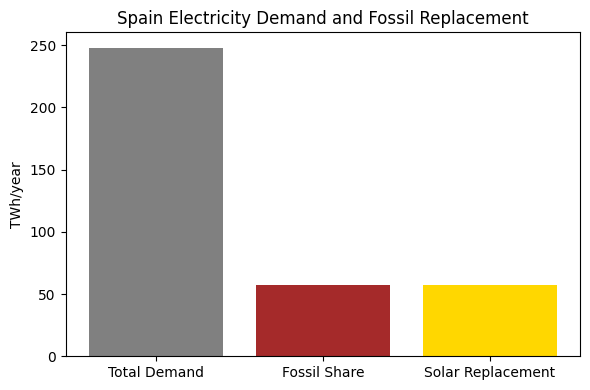

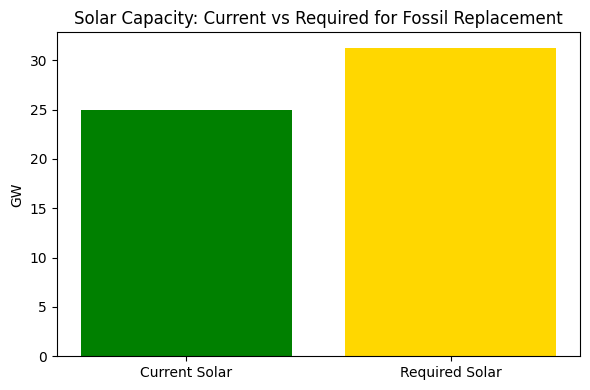

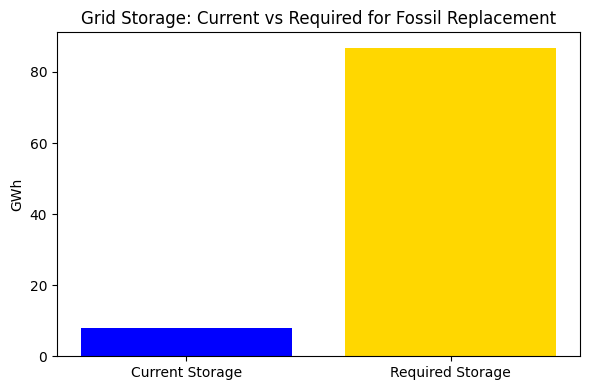

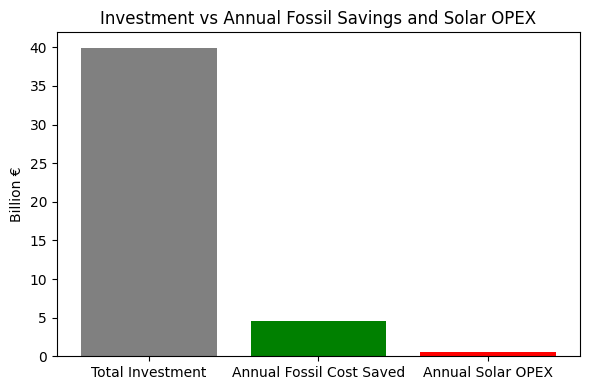

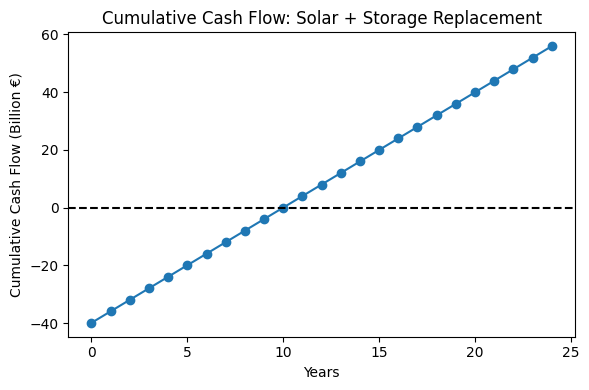

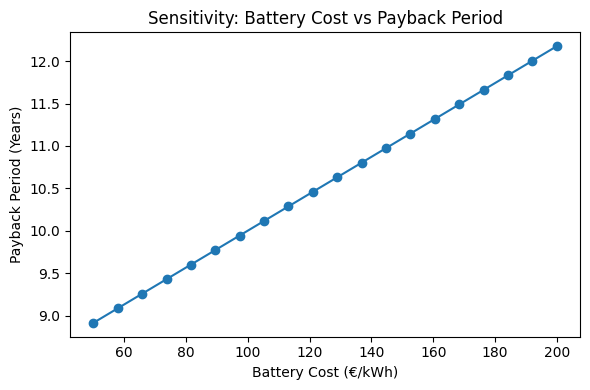

In [14]:
import matplotlib.pyplot as plt

# Define current and required capacities for plotting
current_solar_capacity_gw = 25  # Spain's current solar PV capacity (2024, approx)
required_solar_capacity_gw = solar_capacity_mw / 1000  # MW to GW

current_storage_gwh = 8  # Spain's current grid storage (approx, mostly pumped hydro)
required_storage_gwh = storage_needed_gwh

def plot_energy_demand():
    labels = ['Total Demand', 'Fossil Share', 'Solar Replacement']
    values = [annual_mwh/1e6, fossil_annual_mwh/1e6, fossil_annual_mwh/1e6]  # TWh
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color=['grey', 'brown', 'gold'])
    plt.ylabel('TWh/year')
    plt.title('Spain Electricity Demand and Fossil Replacement')
    plt.tight_layout()
    plt.show()

def plot_capacity_comparison():
    labels = ['Current Solar', 'Required Solar']
    values = [current_solar_capacity_gw, required_solar_capacity_gw]
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color=['green', 'gold'])
    plt.ylabel('GW')
    plt.title('Solar Capacity: Current vs Required for Fossil Replacement')
    plt.tight_layout()
    plt.show()

def plot_storage_comparison():
    labels = ['Current Storage', 'Required Storage']
    values = [current_storage_gwh, required_storage_gwh]
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color=['blue', 'gold'])
    plt.ylabel('GWh')
    plt.title('Grid Storage: Current vs Required for Fossil Replacement')
    plt.tight_layout()
    plt.show()

def plot_investment_vs_savings():
    labels = ['Total Investment', 'Annual Fossil Cost Saved', 'Annual Solar OPEX']
    values = [total_investment/1e9, annual_fossil_cost/1e9, annual_solar_opex/1e9]  # billion €
    colors = ['grey', 'green', 'red']
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color=colors)
    plt.ylabel('Billion €')
    plt.title('Investment vs Annual Fossil Savings and Solar OPEX')
    plt.tight_layout()
    plt.show()

def plot_cumulative_cash_flow():
    years = np.arange(0, 25)
    cash_flow = annual_savings - 0  # no additional annual costs beyond OPEX included
    cumulative_cf = -total_investment + cash_flow * years
    plt.figure(figsize=(6,4))
    plt.plot(years, cumulative_cf/1e9, marker='o')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Years')
    plt.ylabel('Cumulative Cash Flow (Billion €)')
    plt.title('Cumulative Cash Flow: Solar + Storage Replacement')
    plt.tight_layout()
    plt.show()

def plot_sensitivity_battery_cost():
    battery_costs = np.linspace(50, 200, 20)
    roi_years_list = []
    for bc in battery_costs:
        storage_investment_local = required_storage_gwh * 1e6 * bc
        total_investment_local = solar_investment + storage_investment_local
        roi_local = total_investment_local / annual_savings
        roi_years_list.append(roi_local)
    plt.figure(figsize=(6,4))
    plt.plot(battery_costs, roi_years_list, marker='o')
    plt.xlabel('Battery Cost (€/kWh)')
    plt.ylabel('Payback Period (Years)')
    plt.title('Sensitivity: Battery Cost vs Payback Period')
    plt.tight_layout()
    plt.show()

# Generate the graphs
plot_energy_demand()
plot_capacity_comparison()
plot_storage_comparison()
plot_investment_vs_savings()
plot_cumulative_cash_flow()
plot_sensitivity_battery_cost()

# ROI and Investment for Different Fossil Replacement Percentages

Replacing only part of fossil-fuel electricity generation with solar+BESS may be much more cost-effective than replacing 100%. This section analyzes how ROI and investment change as we increase the share of fossil generation replaced, from 10% to 100%.

This helps identify if there is a 'sweet spot' where the transition is most economically attractive, and how diminishing returns set in as we approach full replacement.

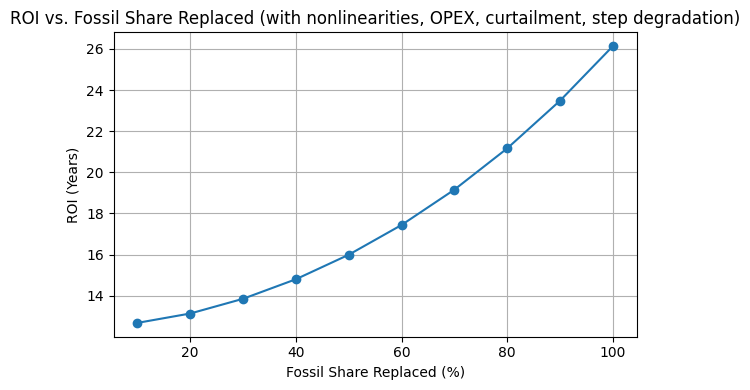

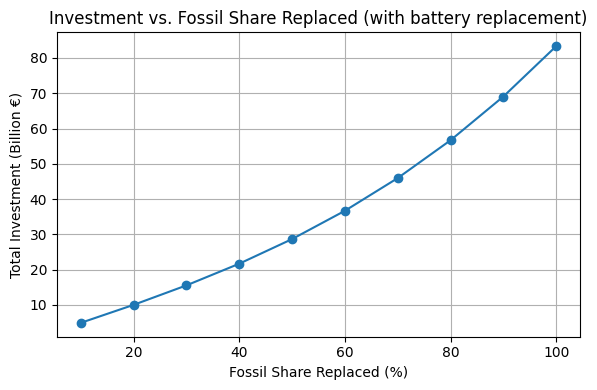

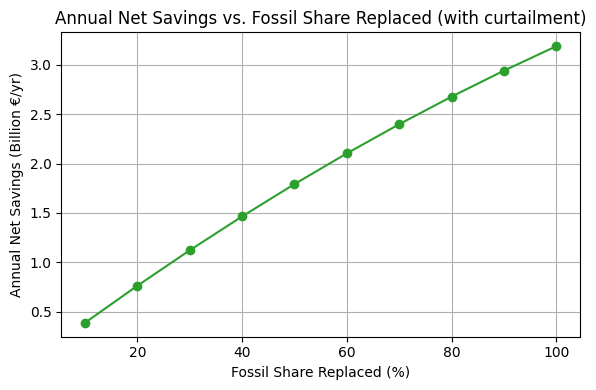

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Improved Analysis: Nonlinear Storage, Fixed OPEX, Curtailment, Step Battery Degradation ---
# This section models:
# - Nonlinear storage scaling (storage needs rise faster at high penetration)
# - Curtailment at high solar shares (not all solar can be used)
# - Fixed and variable OPEX
# - Step battery degradation: battery drops to 80% capacity quickly, then remains stable until replacement at end of life

def storage_needed_gwh_func(t):
    # Storage grows faster at high penetration (example: quadratic scaling)
    return storage_needed_gwh * (1 + 2 * (t**2))

def curtailment_factor(t):
    # 0% curtailment at low t, up to 20% at t=1
    return min(0.2 * t, 0.2)

def battery_effective_capacity_factor():
    # Assume battery degrades to 80% quickly, then stays stable until replacement
    return 0.8

fixed_opex = 5_000_000  # €/year, example fixed OPEX for solar+BESS
battery_lifetime = 12   # years before battery replacement
battery_replacement_cost_fraction = 0.6  # 60% of initial cost for replacement

targets = np.linspace(0.1, 1.0, 10)
roi_list = []
investment_list = []
annual_savings_list = []
for t in targets:
    # Nonlinear storage scaling, adjust for step degradation (size for 80% capacity)
    storage_cap = storage_needed_gwh_func(t) * t / battery_effective_capacity_factor()
    solar_cap = solar_capacity_mw * t
    solar_inv = solar_cap * solar_install_cost_per_mw
    storage_inv = storage_cap * 1e6 * storage_cost_per_kwh
    total_inv = solar_inv + storage_inv
    # Curtailment: not all solar can be used at high penetration
    usable_solar = fossil_annual_mwh * t * (1 - curtailment_factor(t))
    # Fixed and variable OPEX
    annual_opex = usable_solar * cost_per_mwh_solar_opex + fixed_opex
    # Battery replacement at end of life (no continuous degradation)
    years = 25
    battery_replacement_cost = storage_inv * battery_replacement_cost_fraction if years > battery_lifetime else 0
    total_inv_with_replacement = total_inv + battery_replacement_cost
    # Annual savings (use usable_solar, not full fossil replaced)
    annual_sav = usable_solar * cost_per_mwh_fossil - annual_opex
    roi = total_inv_with_replacement / annual_sav if annual_sav > 0 else np.nan
    roi_list.append(roi)
    investment_list.append(total_inv_with_replacement / 1e9)  # in billion €
    annual_savings_list.append(annual_sav / 1e9)  # in billion €/yr

# Plot ROI vs. % replaced
plt.figure(figsize=(6,4))
plt.plot(targets*100, roi_list, marker='o')
plt.xlabel('Fossil Share Replaced (%)')
plt.ylabel('ROI (Years)')
plt.title('ROI vs. Fossil Share Replaced (with nonlinearities, OPEX, curtailment, step degradation)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Investment vs. % replaced
plt.figure(figsize=(6,4))
plt.plot(targets*100, investment_list, marker='o', color='tab:blue')
plt.xlabel('Fossil Share Replaced (%)')
plt.ylabel('Total Investment (Billion €)')
plt.title('Investment vs. Fossil Share Replaced (with battery replacement)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Annual Savings vs. % replaced
plt.figure(figsize=(6,4))
plt.plot(targets*100, annual_savings_list, marker='o', color='tab:green')
plt.xlabel('Fossil Share Replaced (%)')
plt.ylabel('Annual Net Savings (Billion €/yr)')
plt.title('Annual Net Savings vs. Fossil Share Replaced (with curtailment)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary, Next Steps, and Open-Source Collaboration

This notebook provides a transparent, engineering-driven model to estimate the investment and ROI of replacing all fossil-fuel electricity generation in Spain with solar PV and battery energy storage (BESS). The model is:
- **User-configurable**: All key parameters (costs, demand, sizing, efficiency) are easy to adjust.
- **Physically and economically realistic**: Sizing and economics are based on real-world data and best practices.
- **Open-source and collaborative**: Designed for sharing, improvement, and community feedback.

## Next Steps
- **Review and suggest improvements**: Please propose enhancements, corrections, or new features (e.g., more advanced market simulation, nonlinear scaling, fixed OPEX, etc.).
- **Share and discuss**: Share this model on LinkedIn or other platforms to invite feedback from the energy and engineering community.
- **Contribute on GitHub**: The latest version will be published on GitHub for open collaboration. Contributions are welcome!

## How to Share and Collaborate
1. **Publish this notebook to a public GitHub repository** (see README for instructions).
2. **Post the GitHub link on LinkedIn** with a short summary and invitation for feedback (see draft post below).
3. **Encourage open, non-political, engineering-focused discussion and improvement.**

---

### Example LinkedIn Post

> 🚀 **Open-Source Model: Replacing Spain's Fossil Electricity with Solar + Storage**
>
> I've built a transparent, engineering-driven Python model to estimate the investment and ROI of switching all fossil-fuel electricity generation in Spain to solar PV and battery storage (BESS). The model is open-source, user-configurable, and designed for community feedback and improvement.
>
> 🔗 [GitHub Repository Link]
>
> I invite the energy, engineering, and data science community to review, suggest improvements, and collaborate. Let's keep the discussion non-political and focused on technical, economic, and physical realities. All feedback and contributions are welcome!
>
> #EnergyTransition #OpenSource #Engineering #Solar #BESS #ROI #Spain

---

**Thank you for reviewing and contributing!**
